# Database search with Grover's algorithm using Sampler primitive

In this tutorial, you will solve an unstructure search problem using Grover's algorithm with sampler primitive runtime program.

## 1. Set up local development environment

This tutorial requires Qiskit Runtime Service. If you haven't done so already, please follow the steps to set up your [Qiskit Runtime service instance](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-quickstart).

In [3]:
from qiskit_ibm_runtime import IBMRuntimeService

service = IBMRuntimeService()

## 2. Background information

### 2.1 Unstructured search problem

In the olden days, you can look up a person's phone number in a phone book. That is an easy task if you know the person's name because a phone book is orded alphabetically by the owner's name. However, the opposite task, that is you are given a phone number and want to find out who it belongs to, is much more difficult. That is because a phone book is not orded by phone numbers. This is an example of an unstructured search problem. To solve this problem with a classical computer, your best trick is to randomly pick an entry and on average you will need to look up half of the entires ($N/2$, if $N$ is the total number of entries) to find the owner. If you have a quantum computer, however, you can use Grover's algorithm to find the owner in $\sqrt N$ tries. That means to identify the owner in a phone book that has 1 million numbers, you only need to do 1000 tries instead of 500,000 tries!

### 2.2 Grover's algorithm

Classically, the best algorithm solve the unstructured search problem in O(N) steps. The Grover's algorithm improves the the problem to O(sqart N) step. 


Link to textbook?

## 3. Create Grover's circuit

In [120]:
# 3.1 Set up an unstrcutred search problem with a random secret string
# Generate a random secret answer for the quantum computer to search for

import random
secret = random.randint(0,7)
secret_string = format(secret, '03b')

In [121]:
# We will reveal the secrect anwser at the end to check whether the quantum computer can find it successfully
# Next, set up the unstructrued search problem using AmplificationProblem class in Qiskit

from qiskit.quantum_info import Statevector
from qiskit.algorithms import AmplificationProblem, Grover

oracle = Statevector.from_label(secret_string)
problem = AmplificationProblem(oracle, is_good_state=secret_string)

In [122]:
# 3.2 Construct Grover's circuit for the problem
# Grover's algorithm's accuracy in finding the correct answer increases with the number of iterations
# Let's create a circuit with 1 and 2 iterations to see the effect
grover_circuits = []
for iteration in range(1,3):
    grover = Grover(iterations=iteration)
    grover_circuit = grover.construct_circuit(problem)
    # the circuit needs to decomposed to a certain level otherwise IBMSampler will complain
    # it's probably a bug
    grover_circuit = grover_circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
    grover_circuit.measure_all()
    grover_circuits.append(grover_circuit)

In [123]:
# Let's look at the circuits
#grover_circuits[0].draw()

In [124]:
#grover_circuits[1].draw()

## 4. Submit to IBM Cloud

In [130]:
# Now that the grover circuit is created, let's submit it to IBM Cloud using the latest Sampler problem
# 4.1 first we will connect the service we have setup in step 1

In [134]:
from qiskit_ibm_runtime import IBMRuntimeService
service = IBMRuntimeService()

In [132]:
# Grover's algorithm determines the correct answer based on the highest probability of measurement outcome
# The Sampler program is perfect for getting probabilities, so we will use that.

# highlight the session model
# and batch

from qiskit_ibm_runtime import IBMSampler

sampler_factory = IBMSampler(service=service)

with sampler_factory(circuits=grover_circuits) as sampler:
    result = sampler(circuit_indices=[0,1], shots=1000)
    print(result)

SamplerResult(quasi_dists=[{'000': 0.073, '001': 0.076, '010': 0.076, '011': 0.063, '100': 0.448, '101': 0.097, '110': 0.092, '111': 0.075}, {'000': 0.095, '001': 0.067, '010': 0.067, '011': 0.06, '100': 0.481, '101': 0.085, '110': 0.077, '111': 0.068}], metadata=[{'header_metadata': {}, 'shots': 1000}, {'header_metadata': {}, 'shots': 1000}])


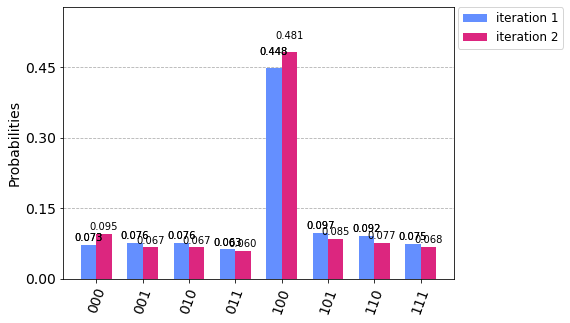

In [133]:
# Let's look at the results
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.quasi_dists, legend=['iteration 1', 'iteration 2'])

In [129]:
# As you can see, "110"
# Did the quantum computer find the correct answer? Let's now reveal our secret string. 
d = result.quasi_dists[1]
highest_prob = max(d, key=d.get)
print(f"Quantum answer: {highest_prob}")
print(f"Correct answer: {secret_string}")
print('Success!' if highest_prob == secret_string else 'Failure!')

Quantum answer: 100
Correct answer: 100
Success!


You can re-run the tutorials a few times to generate other random secret strings to see that we are not cheating :D The quantum computer finds the correct answer every time.